# Question: What are the most common two-word phrases from commit messages?
Purpose: We want to try to summarize the content being worked on from the perspective of individual users as well as all users.

In [1]:
import os
from github import Github
from dotenv import load_dotenv
load_dotenv()

import re
import nltk
nltk.download('stopwords')
from collections import Counter
import operator

import matplotlib.pyplot as plt
import seaborn as sns

import bq_helper
import db_dtypes

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ericvaughan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Clean up the words in the messages
def clean_messages(messages):
    cleaned_messages = []
    for message in messages:
        # Make all messages lowercase
        message = message.lower()
        
        # Ignore initial commit messages
        if (message == "initial commit" or message == "first commit"):
            continue
          
        # Remove special characters
        message = re.sub('[,"\'&\|:@>*;/=\+_™\[\]]', "", message)
        if (len(message) == 0):
            continue
        
        # Separate each message into a list of words
        words = re.split('\s+', message)
        
        # Remove stop words
        stop_words = nltk.corpus.stopwords.words('english')
        for word in words:
            if (word in stop_words):
                words.remove(word)
        cleaned_messages.append(words)
    return cleaned_messages

In [5]:
# Create consecutive two-word phrases
# For example: "sample commit message here" -> "sample commit", "commit message", "message here"
# If a message just has one word, it is included as a one-word phrase
def create_phrases(messages):
    phrases = []
    for message in messages:
        if (len(message) < 2):
            continue
        elif (len(message) >= 2):
            tmp = list(map(' '.join, zip(message[:-1], message[1:])))
            for phrase in tmp:
                if (phrase[0] != " " and phrase[-1] != " "):
                    phrases.append(phrase)
    return phrases
                

In [6]:
def find_n_most_common_phrases(phrases, n=15):
    # Count the frequency of each commit message phrase
    counts = Counter(phrases)
    counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
    
    # Return the top n most common phrases
    min_len = min(len(counts), n)
    return counts[0:min_len]

In [7]:
# Graph the most common commit phrases and their corresponding frequencies
def graph_phrases(phrases):
    keys = [phrase[0] for phrase in phrases]
    vals = [phrase[1] for phrase in phrases]
    plt.figure(figsize=(6, 8))
    sns.barplot(x=vals, y=keys, color="deepskyblue")
    plt.title("Most Common Two-Word Phrases\nfrom Commit Messages")
    plt.xlabel("Frequency")
    plt.ylabel("Phrases")
    plt.show()

# Commit Message Analysis for Individual Users

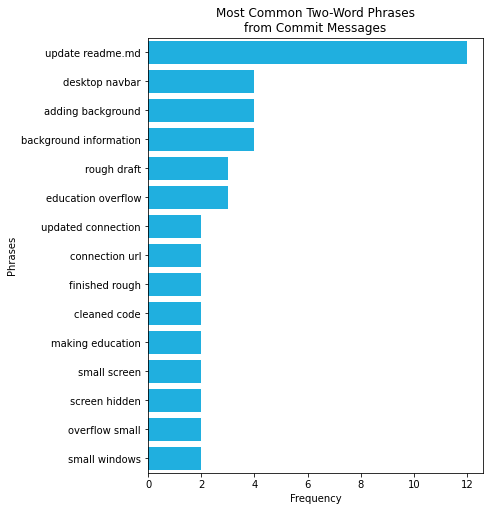

In [19]:
access_token = os.environ.get('GITHUB_ACCESS_TOKEN')
g = Github(access_token)

# Replace username with the GitHub username of the individual whom you want to analyze
username = "VaughanEric"

# Obtain all the user's commit messages from their repos
user = g.get_user(username)
repos = user.get_repos()
messages = []
for repo in repos:
    commits = repo.get_commits(author=user)
    for commit in commits:
        messages.append(commit.commit.message)

# Clean the commit messages and create the two-word phrases
messages = clean_messages(messages)
phrases = create_phrases(messages)

# Find and graph the most common phrases
phrases = find_n_most_common_phrases(phrases)
graph_phrases(phrases)

# Commit Messsage Analysis for All Users

In [8]:
github_repos = bq_helper.BigQueryHelper(active_project="bigquery-public-data", dataset_name="github_repos")
github_repos.head("commits")
query = """SELECT subject
            FROM bigquery-public-data.github_repos.commits
            LIMIT 100000
        """
subjects = github_repos.query_to_pandas_safe(query, max_gb_scanned=12)

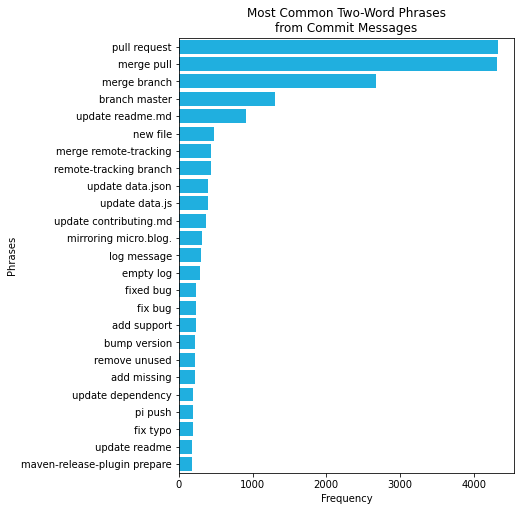

In [9]:
# Messages from 100,000 commits
messages = subjects["subject"]

# Clean the commit messages and create the two-word phrases
messages = clean_messages(messages)
phrases = create_phrases(messages)

# Find and graph the most common phrases
phrases = find_n_most_common_phrases(phrases, 25)
graph_phrases(phrases)